In [1]:
import time
import os
import math
import numpy as np
import cv2
import pandas as pd
import pyautogui as pa
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.stats.multitest import fdrcorrection
import pylab as P
import matplotlib.image as image
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)

from lib.auto_GUI.auto_GUI_base import AutoGUIBase
from lib.auto_GUI.auto_PhotoZ import AutoPhotoZ
from lib.file.TIF import *
from lib.analysis.ROI_identification import *
from lib.file.ROI_writer import ROIFileWriter
from lib.file.ROI_reader import ROIFileReader
from lib.file.TSV import RegionExporter
from lib.analysis.align import ImageAlign
from lib.file.DAT import TracesDAT
from lib.trace import Tracer
from lib.utilities import *
from lib.analysis.laminar_dist import *

In [2]:
############## QUESTION: ##################################
# Does PV IN velocity jump abruptly at barrel/layer boundary?
# analyze velocity BUT:
#            - chunked by barrel for intralaminar CVs
#            - chunked by layer for interlaminar CVs
# 
###########################################################

In [3]:
# Load data, not from Drive for Desktop since PhotoZ complains about loading zda from Drive
data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/Kate's/"
# data_dir = 'C:/Users/jjudg/OneDrive/Desktop/'
csv_filename = 'raw_velocity_data_JJ_KS_compare_v7.csv'

synaptic_column = "Kate's Synaptic"
latency_column = "Kate's Mono Latency" #'Latency_Mono_Raw'

# load the all-data CSV dir
df = pd.read_csv(data_dir + csv_filename)
df = pd.DataFrame(df)
df

,Date,Id,Genotype,Birthdate,Age_Days,Sex,Tx,Tx_Start,Slice_Loc_Run,Trial_x_Time,...,Latency_Mono_Raw,Kate's Mono Latency,Mono_Resp_Start_Time,Mono_Resp_End_Time,Layer,Distance,window start,window len,window end,Unnamed: 35
0,10_02_2020,471989,PV,08_04_2020,66,M,Run_Control,09_04_2020,02_01_05,5x15,...,47.2902,47.2803,46.5,50.5,2_3,2.76,93,8,101,NaN
1,10_02_2020,471989,PV,08_04_2020,66,M,Run_Control,09_04_2020,02_01_05,5x15,...,47.2542,47.2422,46.5,50.5,2_3,5.82,93,8,101,NaN
2,10_02_2020,471989,PV,08_04_2020,66,M,Run_Control,09_04_2020,02_01_05,5x15,...,47.3070,47.2978,46.5,50.5,2_3,8.78,93,8,101,NaN
3,10_02_2020,471989,PV,08_04_2020,66,M,Run_Control,09_04_2020,02_01_05,5x15,...,47.5374,47.5344,46.5,50.5,2_3,11.63,93,8,101,NaN
4,10_02_2020,471989,PV,08_04_2020,66,M,Run_Control,09_04_2020,02_01_05,5x15,...,47.4508,47.4433,46.5,50.5,4,14.74,93,8,101,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1782,09_06_2021,5596,FXR1,07_24_2021,47,F,FXR1_Control,NaN,08_01_04,5x15,...,50.5024,50.4962,49.5,53.0,2_3_D,31.04,99,7,106,NaN
1783,09_06_2021,5596,FXR1,07_24_2021,47,F,FXR1_Control,NaN,08_01_04,5x15,...,50.9913,50.9979,49.5,53.0,2_3_D,34.04,99,7,106,NaN
1784,09_06_2021,5596,FXR1,07_24_2021,47,F,FXR1_Control,NaN,08_01_04,5x15,...,50.9794,50.9916,49.5,53.0,2_3_D,37.28,99,7,106,NaN
1785,09_06_2021,5596,FXR1,07_24_2021,47,F,FXR1_Control,NaN,08_01_04,5x15,...,51.7702,46.2476,49.5,53.0,2_3_D,40.46,99,7,106,NaN


In [4]:
# Fill in more of synapse_count_map from file
dir_name = 'Choosing trajectories'
filename = 'raw_velocity_data_JJ.csv'

filename_combined = data_dir + csv_filename

synapse_count_map = {}

df_combined = pd.read_csv(filename_combined)
df_combined = pd.DataFrame(df_combined, columns=['Date', 'Slice_Loc_Run',
                              'Stim_Layer', 'Laminar', 'ROI_Id', 'Synaptic', 'Kate\'s Synaptic',
                               'Latency_Mono_Raw', 'Kate\'s Mono Latency', 'Distance', 'Layer'])
print(df_combined)
for date in df_combined.Date.unique():
    cv_subset_date = df_combined[(df_combined['Date'] == date)]
    for rec_id in cv_subset_date.Slice_Loc_Run.unique():
        cv_subset_rec_id = cv_subset_date[(cv_subset_date['Slice_Loc_Run'] == rec_id)]
        for laminar_val in cv_subset_rec_id.Laminar.unique():
            cv_subset_lam = cv_subset_rec_id[(cv_subset_rec_id['Laminar'] == laminar_val)]
            for layer_val in cv_subset_lam.Stim_Layer.unique():
                plot_key = date + " " + rec_id + " " + laminar_val + " " + layer_val
                cv_subset = cv_subset_lam[(cv_subset_lam['Stim_Layer'] == layer_val)]
                if plot_key not in synapse_count_map:
                    synapse_count_map[plot_key] = {0: [], 1: [], 2:[]}
                    for idx, row in cv_subset.iterrows():
                        roi_id_0 = int(row['ROI_Id']) - 1
                        if type(row[synaptic_column]) == str:
                            
                            if "Mono" in row[synaptic_column]:
                                # print(roi_id_0, 1)
                                synapse_count_map[plot_key][1].append(roi_id_0)
                            elif "Disyn" in row[synaptic_column]:
                                # print(roi_id_0, 2)
                                synapse_count_map[plot_key][2].append(roi_id_0)
                            elif "Dir" in row[synaptic_column]:
                                synapse_count_map[plot_key][0].append(roi_id_0)
                

            Date Slice_Loc_Run Stim_Layer Laminar  ROI_Id      Synaptic  \
0     10_02_2020      02_01_05        2_3   Inter       1   Direct_resp   
1     10_02_2020      02_01_05        2_3   Inter       2   Direct_resp   
2     10_02_2020      02_01_05        2_3   Inter       3   Direct_resp   
3     10_02_2020      02_01_05        2_3   Inter       4   Direct_resp   
4     10_02_2020      02_01_05        2_3   Inter       5  Monosynaptic   
...          ...           ...        ...     ...     ...           ...   
1782  09_06_2021      08_01_04        2_3   Intra      10       No_resp   
1783  09_06_2021      08_01_04        2_3   Intra      11    Disynaptic   
1784  09_06_2021      08_01_04        2_3   Intra      12    Disynaptic   
1785  09_06_2021      08_01_04        2_3   Intra      13    Disynaptic   
1786  09_06_2021      08_01_04        2_3   Intra      14    Disynaptic   

     Kate's Synaptic  Latency_Mono_Raw  Kate's Mono Latency  Distance  Layer  
0        Direct_resp

#  10_02_2020 02_01_05 Inter 2_3
2 Velocity: 219.6 um / ms
	P-value: 0.21291254165248405
2 Velocity: 191.97 um / ms
	P-value: 0.0026962885031612312
Num points: 14


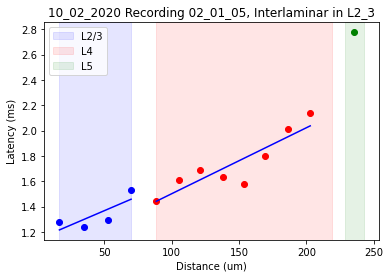

#  10_02_2020 02_01_05 Intra 2_3
2 Velocity: 104.75 um / ms
	P-value: 0.004048633209862745
2 Velocity: 49.01 um / ms
	P-value: 0.0003543484259638712
2 Velocity: -22.55 um / ms
	P-value: 0.03196181132196996
Num points: 23


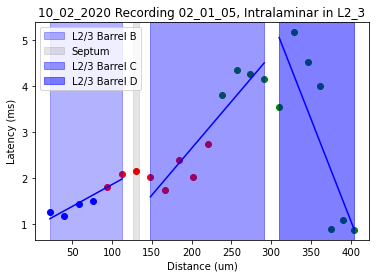

#  10_27_2020 03_01_06 Intra 4
2 Velocity: 2349.09 um / ms
	P-value: 0.9005646247150294
2 Velocity: 73.76 um / ms
	P-value: 0.015578937560852619
2 Velocity: 15.18 um / ms
	P-value: 0.47024449802970725
Num points: 14


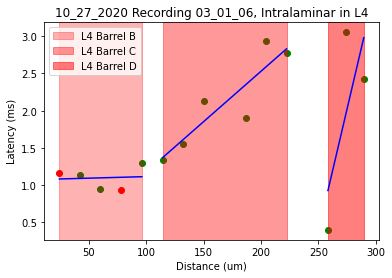

#  12_13_2020 02_01_02 Intra 4
2 Velocity: 144.02 um / ms
	P-value: 0.4003775594636112
2 Velocity: 200.5 um / ms
	P-value: 0.865422619554888
Num points: 15


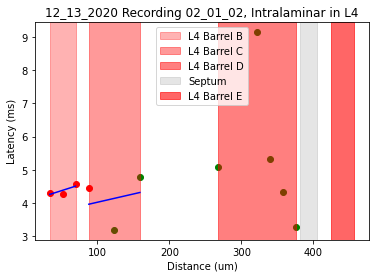

#  12_28_2020 03_01_08 Intra 2_3
2 Velocity: -44.63 um / ms
	P-value: nan
Num points: 14


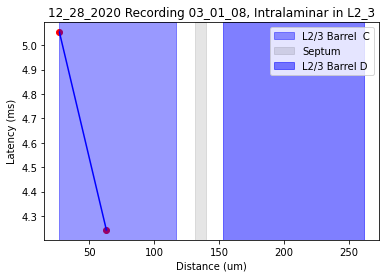

#  12_28_2020 04_01_01 Inter_L5 4
2 Velocity: 48.25 um / ms
	P-value: 0.07165758369713773
Num points: 9


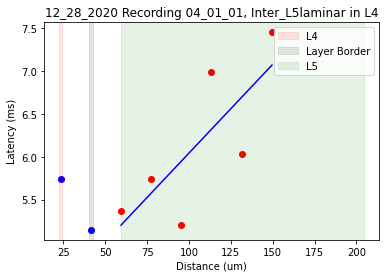

#  12_28_2020 06_01_01 Inter_L23 4
2 Velocity: -41.56 um / ms
	P-value: 0.4308890879896948
Num points: 10


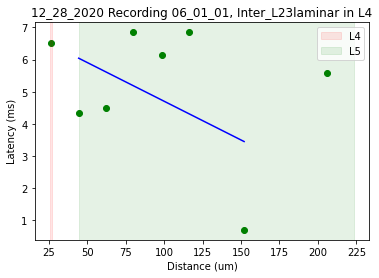

#  12_28_2020 08_01_04 Inter_L23 4
2 Velocity: -772.53 um / ms
	P-value: 0.7807302314168982
2 Velocity: 452.26 um / ms
	P-value: 0.3969549919434342
Num points: 17


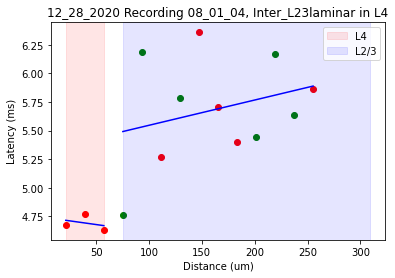

#  12_28_2020 10_01_01 Inter_L23 4
2 Velocity: -144.31 um / ms
	P-value: 0.411787820577567
Num points: 12


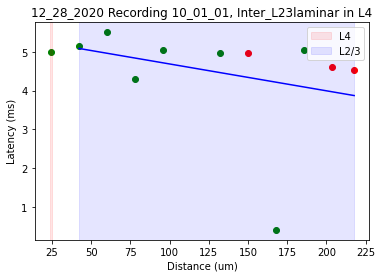

#  12_28_2020 11_01_06 Inter_L23 4
2 Velocity: -72.96 um / ms
	P-value: nan
2 Velocity: -587.42 um / ms
	P-value: 0.9438191168196719
Num points: 10


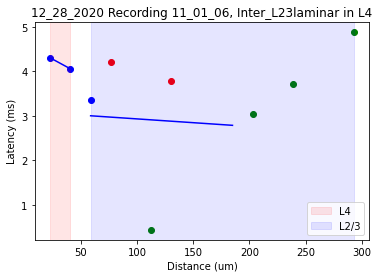

#  12_29_2020 04_01_01 Inter_L23 4
2 Velocity: -13.55 um / ms
	P-value: nan
2 Velocity: 393.2 um / ms
	P-value: 0.25560045513773
Num points: 16


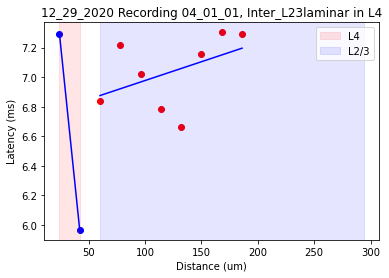

#  12_29_2020 06_01_01 Inter_L23 4
2 Velocity: 146.45 um / ms
	P-value: 0.05299671670109668
Num points: 17


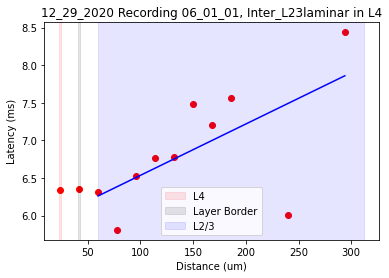

#  12_29_2020 07_01_03 Intra 4
2 Velocity: 45.79 um / ms
	P-value: nan
2 Velocity: 51.14 um / ms
	P-value: 0.005888238854240363
Num points: 16


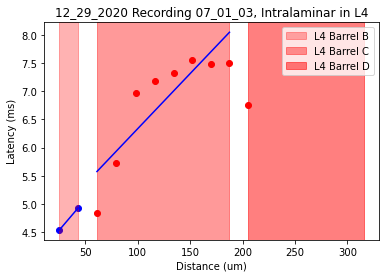

#  12_29_2020 09_01_02 Inter_L23 4
2 Velocity: 59.76 um / ms
	P-value: nan
2 Velocity: 160.15 um / ms
	P-value: 0.022854088083795687
Num points: 11


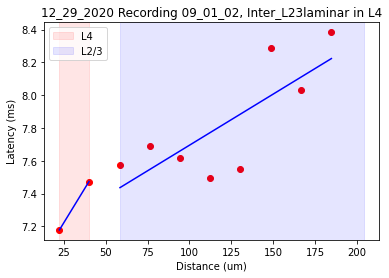

#  01_11_2021 09_01_01 Inter 2_3
2 Velocity: 14.45 um / ms
	P-value: 0.4292260077719859
2 Velocity: -103.51 um / ms
	P-value: 0.5875128372027982
2 Velocity: 20.97 um / ms
	P-value: nan
Num points: 10


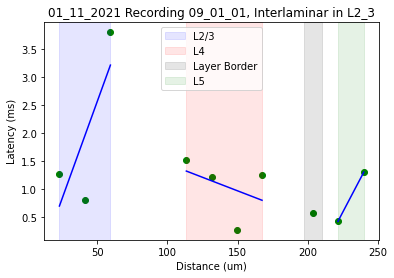

#  01_18_2021 04_01_02 Inter 2_3
2 Velocity: -1.08 um / ms
	P-value: nan
2 Velocity: 406.21 um / ms
	P-value: 0.7664190271259437
2 Velocity: 122.97 um / ms
	P-value: 0.38635092668858534
Num points: 20


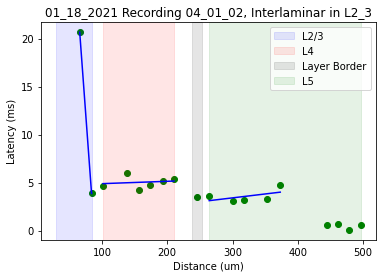

#  01_18_2021 05_01_03 Inter 2_3
2 Velocity: 45.12 um / ms
	P-value: 0.017622772169753807
2 Velocity: 646.82 um / ms
	P-value: 0.681337779386783
2 Velocity: -21.65 um / ms
	P-value: 0.07713014552619082
Num points: 15


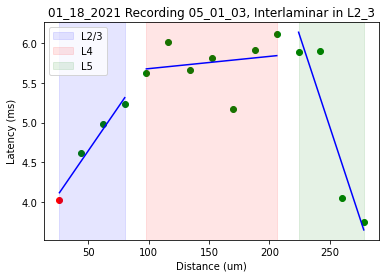

#  01_18_2021 07_01_02 Inter 2_3
2 Velocity: 63.28 um / ms
	P-value: 0.011869313514472665
2 Velocity: 398.11 um / ms
	P-value: 0.283771547506159
2 Velocity: -45.82 um / ms
	P-value: 0.4412728675774775
Num points: 20


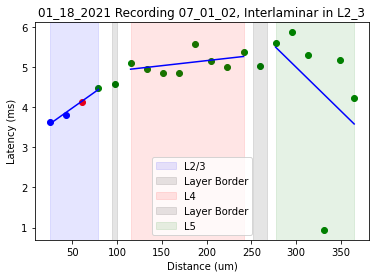

#  01_19_2021 05_01_01 Inter 2_3
2 Velocity: 42.1 um / ms
	P-value: nan
2 Velocity: -27.65 um / ms
	P-value: 0.04598116529636496
Num points: 14


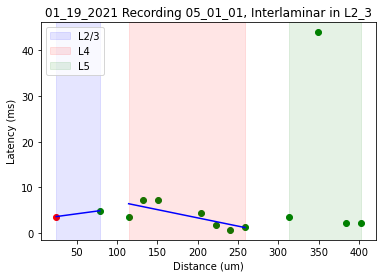

#  03_02_2021 03_01_02 Inter 5
2 Velocity: 78.98 um / ms
	P-value: 0.5451402527568229
2 Velocity: 257.21 um / ms
	P-value: 0.6158085120273212
2 Velocity: 472.28 um / ms
	P-value: 0.8715104686291173
Num points: 24


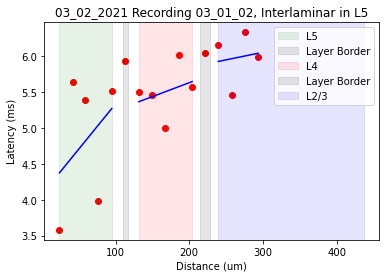

#  03_02_2021 05_01_02 Inter 5
2 Velocity: 98.35 um / ms
	P-value: 0.13839646145840573
2 Velocity: 752.45 um / ms
	P-value: 0.33099938923429884
2 Velocity: 87.99 um / ms
	P-value: 0.0059002918695967325
Num points: 23


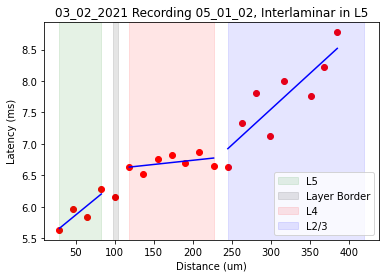

#  03_02_2021 07_01_03 Inter 5
2 Velocity: 111.26 um / ms
	P-value: 0.27626126509314547
2 Velocity: -20563.9 um / ms
	P-value: 0.9513692274177512
2 Velocity: -259237.13 um / ms
	P-value: 0.9986137521307791
Num points: 21


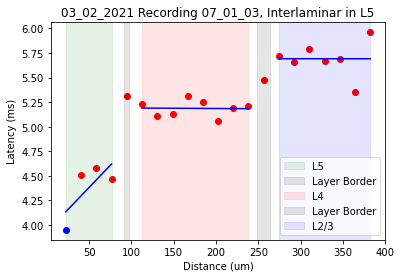

#  03_02_2021 08_01_01 Intra 5
2 Velocity: 25.22 um / ms
	P-value: nan
2 Velocity: 93.74 um / ms
	P-value: 0.11405678002224837
2 Velocity: 6.45 um / ms
	P-value: 0.33225276785289976
Num points: 13


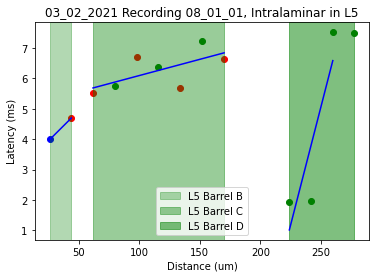

#  03_02_2021 08_01_01 Inter 5
2 Velocity: 19.31 um / ms
	P-value: nan
2 Velocity: 99.05 um / ms
	P-value: 0.001887020380152965
2 Velocity: 277.95 um / ms
	P-value: 0.5918165056430696
Num points: 20


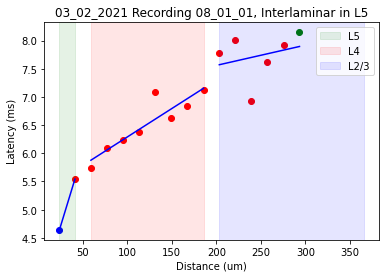

#  03_09_2021 03_01_02 Inter 5
2 Velocity: 53.21 um / ms
	P-value: nan
2 Velocity: 322.52 um / ms
	P-value: 0.04196911024450932
2 Velocity: 193.84 um / ms
	P-value: 0.013317512124037282
Num points: 21


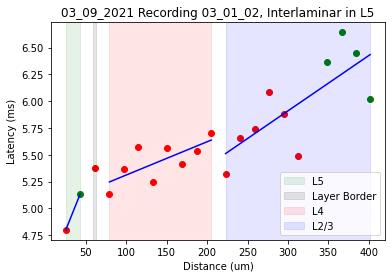

#  03_09_2021 05_01_02 Inter 5
2 Velocity: 42.47 um / ms
	P-value: 0.0719799050770009
2 Velocity: 473.99 um / ms
	P-value: 0.35357519161410844
2 Velocity: 259.22 um / ms
	P-value: 0.09902516421776453
Num points: 18


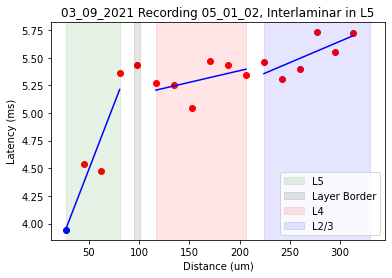

#  03_23_2021 05_01_02 Inter 5
2 Velocity: 260.83 um / ms
	P-value: 0.5737634727761752
2 Velocity: 147.1 um / ms
	P-value: 0.10578119161232868
Num points: 14


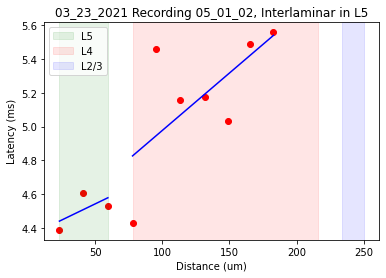

#  03_23_2021 05_01_02 Intra 5
2 Velocity: 116.52 um / ms
	P-value: 0.04585874072331284
2 Velocity: -119.95 um / ms
	P-value: 0.42737611963790273
Num points: 18


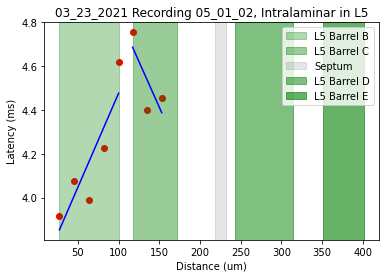

#  03_23_2021 06_01_01 Inter 5
2 Velocity: 42.85 um / ms
	P-value: nan
2 Velocity: 6440.16 um / ms
	P-value: 0.9000040448191455
2 Velocity: 329.86 um / ms
	P-value: 0.9147336270421773
Num points: 17


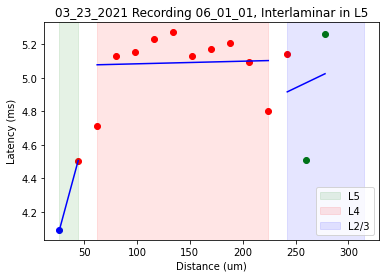

#  03_23_2021 07_01_01 Inter 5
2 Velocity: 48.8 um / ms
	P-value: 0.03917766381765898
2 Velocity: 269.67 um / ms
	P-value: 0.01525574242364068
2 Velocity: 69.84 um / ms
	P-value: 0.004372292758759038
Num points: 21


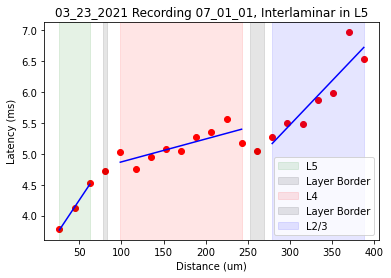

#  04_13_2021 03_01_02 Inter 5
2 Velocity: 162.88 um / ms
	P-value: 0.012013963082678545
2 Velocity: 53.61 um / ms
	P-value: 0.10435720759974662
Num points: 16


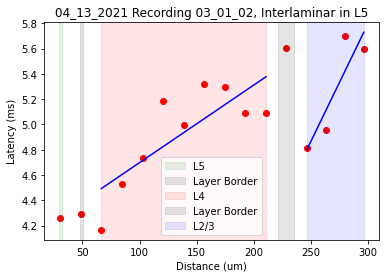

#  04_13_2021 03_01_02 Intra 5
2 Velocity: 62.57 um / ms
	P-value: 0.08940900315821824
2 Velocity: 29.48 um / ms
	P-value: nan
Num points: 17


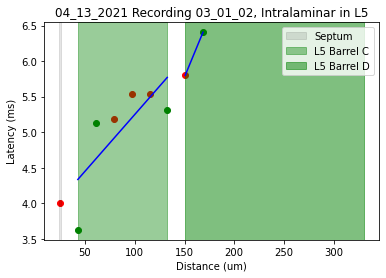

#  04_13_2021 04_01_02 Inter 2_3
2 Velocity: 1063.35 um / ms
	P-value: 0.8981735076324622
2 Velocity: -20.13 um / ms
	P-value: 0.30389949294200025
Num points: 12


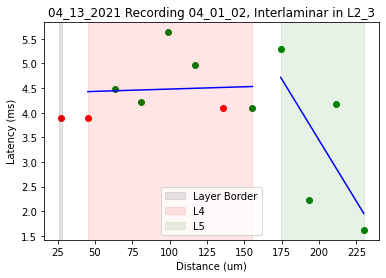

#  04_13_2021 05_01_01 Intra 2_3
2 Velocity: 100.6 um / ms
	P-value: 0.07804562540191484
2 Velocity: 117.04 um / ms
	P-value: 0.023157876344968655
2 Velocity: 96.91 um / ms
	P-value: 0.1376148043710292
Num points: 18


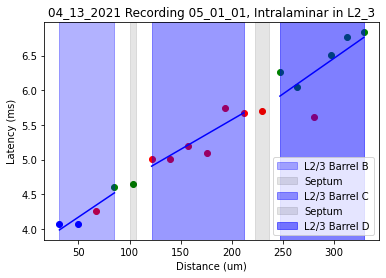

#  04_13_2021 05_01_01 Inter 2_3
2 Velocity: 121.55 um / ms
	P-value: nan
2 Velocity: 112.29 um / ms
	P-value: 0.02105224477003173
2 Velocity: 80.48 um / ms
	P-value: 0.15740962802630157
Num points: 16


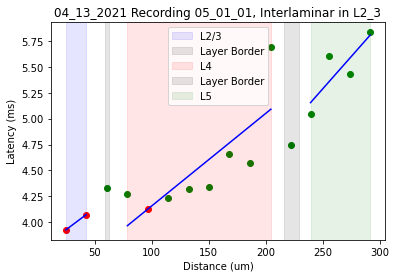

#  04_13_2021 06_01_01 Inter 2_3
2 Velocity: 179.64 um / ms
	P-value: 0.02339060805736964
2 Velocity: 92.83 um / ms
	P-value: 0.006312935093267477
2 Velocity: -87.53 um / ms
	P-value: 0.12457310488714816
Num points: 22


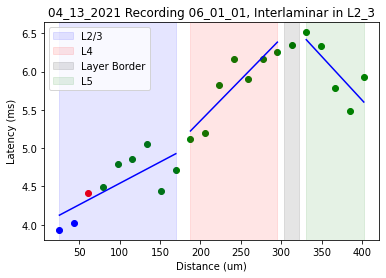

#  04_13_2021 07_01_02 Inter_L23 4
2 Velocity: 616.28 um / ms
	P-value: 0.8375011650372264
2 Velocity: 1390.39 um / ms
	P-value: 0.7655951203506974
Num points: 21


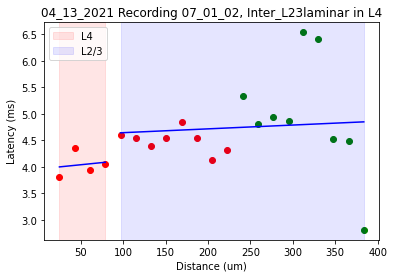

#  04_13_2021 07_01_02 Intra 4
2 Velocity: 44.71 um / ms
	P-value: 0.059374818323321366
2 Velocity: 623.7 um / ms
	P-value: 0.030370891868670657
Num points: 14


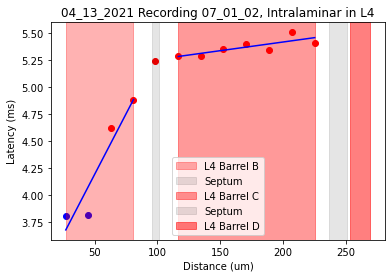

#  04_13_2021 08_01_01 Inter 2_3
2 Velocity: 60.43 um / ms
	P-value: 0.0001422421113415737
2 Velocity: -16.25 um / ms
	P-value: nan
Num points: 12


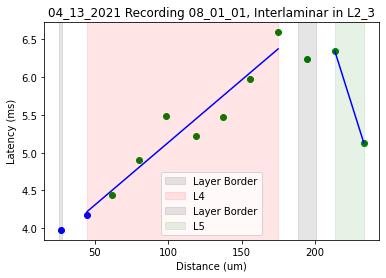

#  05_25_2021 01_01_04 Intra 2_3
2 Velocity: -46.8 um / ms
	P-value: nan
2 Velocity: 1197.25 um / ms
	P-value: 0.324002071098684
Num points: 18


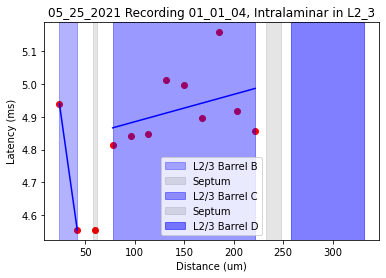

#  05_25_2021 02_01_03 Inter 2_3
2 Velocity: -162.35 um / ms
	P-value: nan
2 Velocity: 96.83 um / ms
	P-value: 0.001514032438889688
2 Velocity: 93.75 um / ms
	P-value: 0.7877134727728683
Num points: 17


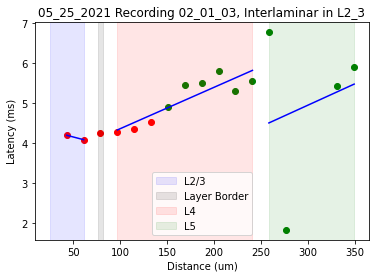

#  05_25_2021 02_01_03 Intra 2_3
2 Velocity: 35.41 um / ms
	P-value: 0.2232314940013375
2 Velocity: 67.08 um / ms
	P-value: 0.1740155285846192
Num points: 12


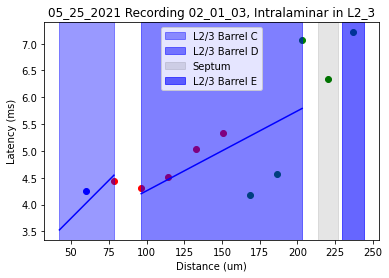

#  05_25_2021 03_01_05 Inter 2_3
2 Velocity: -259.4 um / ms
	P-value: 0.10075123542082613
2 Velocity: -236.21 um / ms
	P-value: 0.20806389351728974
Num points: 18


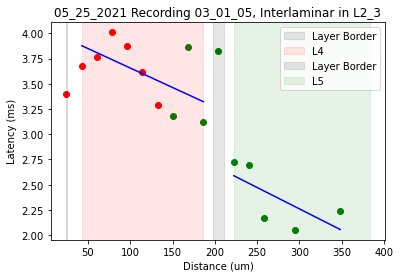

#  05_25_2021 04_01_03 Inter 2_3
2 Velocity: 24.72 um / ms
	P-value: 0.2372379237444403
2 Velocity: 199.16 um / ms
	P-value: 0.0001345658344395269
2 Velocity: 59.1 um / ms
	P-value: 0.05670270444912018
Num points: 15


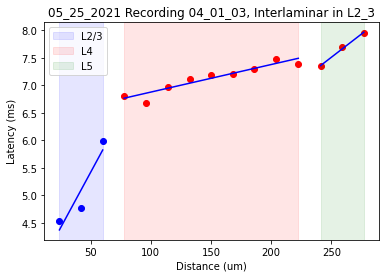

#  05_25_2021 05_01_04 Inter 2_3
2 Velocity: 363.2 um / ms
	P-value: 0.035366593679226205
Num points: 12


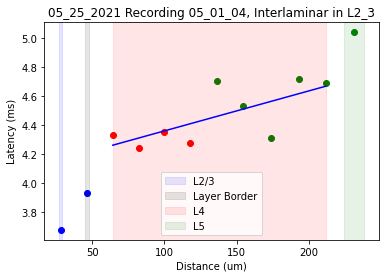

#  05_25_2021 07_01_03 Intra 4
2 Velocity: 209.78 um / ms
	P-value: 0.0012804333741355499
2 Velocity: 176.34 um / ms
	P-value: 0.0649163231819025
Num points: 15


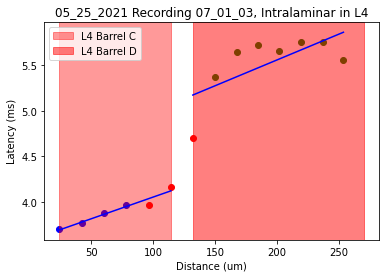

#  05_25_2021 08_01_04 Inter_L23 4
2 Velocity: 517.84 um / ms
	P-value: 0.32383570320240906
2 Velocity: 334.49 um / ms
	P-value: 0.01106375297963258
Num points: 22


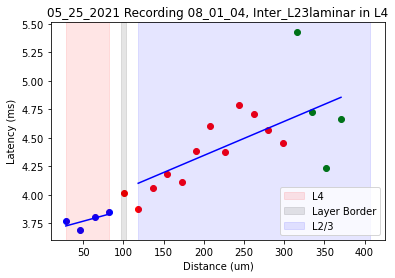

#  05_25_2021 08_01_04 Intra 4
2 Velocity: 133.43 um / ms
	P-value: nan
2 Velocity: 209.9 um / ms
	P-value: 0.014467536052915909
Num points: 12


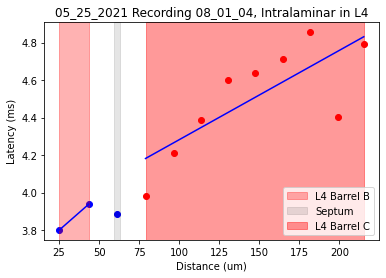

#  05_25_2021 09_01_04 Inter 2_3
2 Velocity: -1721.65 um / ms
	P-value: 0.7104873780863193
2 Velocity: 160.91 um / ms
	P-value: 0.0010315848031326395
2 Velocity: 344.69 um / ms
	P-value: 0.7453044894118455
Num points: 16


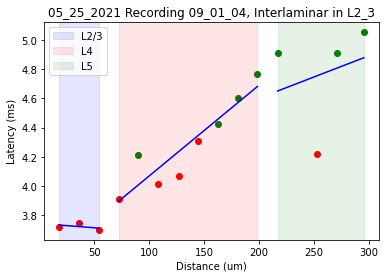

#  05_25_2021 09_01_04 Intra 2_3
2 Velocity: 102.25 um / ms
	P-value: 0.000167187904661166
2 Velocity: 78.16 um / ms
	P-value: 0.27267979059962394
Num points: 17


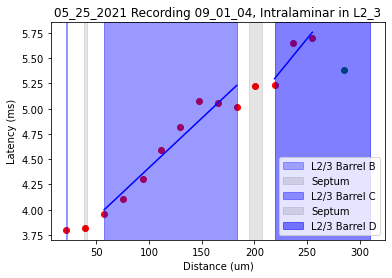

#  05_26_2021 02_01_04 Inter 2_3
2 Velocity: -159.26 um / ms
	P-value: nan
2 Velocity: 475.94 um / ms
	P-value: 0.45677014521655107
2 Velocity: 1040.82 um / ms
	P-value: 0.9709827182799639
Num points: 17


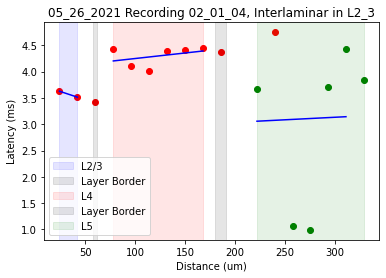

#  05_26_2021 04_01_05 Inter 2_3
2 Velocity: -5924.35 um / ms
	P-value: 0.9589796849512142
2 Velocity: -39.2 um / ms
	P-value: 0.3577784141764547
2 Velocity: 39.31 um / ms
	P-value: 0.8394546490749725
Num points: 16


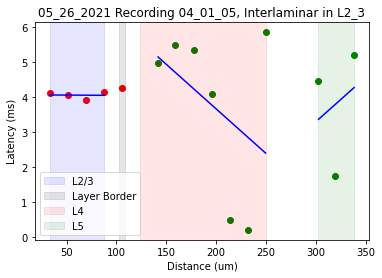

#  05_26_2021 04_01_05 Intra 2_3
2 Velocity: 90.08 um / ms
	P-value: 0.004792792727669459
2 Velocity: 29.66 um / ms
	P-value: 0.12751130828940224
Num points: 12


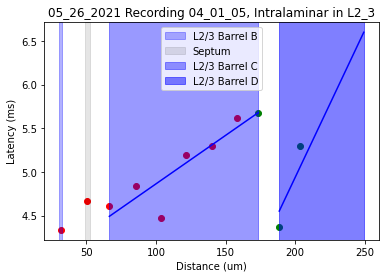

#  05_26_2021 05_01_03 Inter 2_3
2 Velocity: 139.76 um / ms
	P-value: 0.5393499807723712
2 Velocity: 5.33 um / ms
	P-value: 0.12168221598749542
2 Velocity: 51.38 um / ms
	P-value: nan
Num points: 17


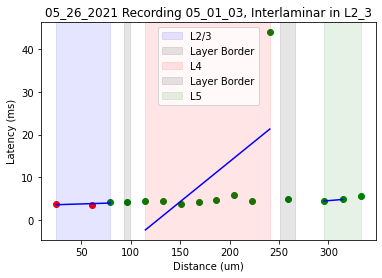

#  05_26_2021 05_01_03 Intra 2_3
2 Velocity: 74.91 um / ms
	P-value: nan
2 Velocity: -373.1 um / ms
	P-value: 0.6590096895627358
Num points: 14


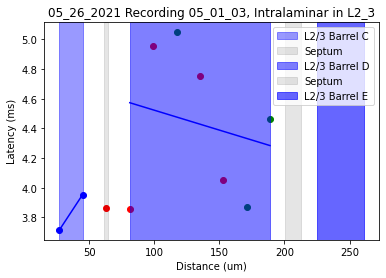

#  05_26_2021 07_01_03 Inter_L5 4
2 Velocity: 130.94 um / ms
	P-value: 0.0017390463141178977
Num points: 17


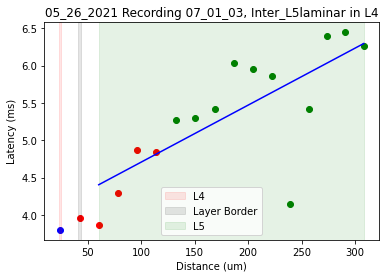

#  05_26_2021 07_01_03 Intra 4
2 Velocity: 115.57 um / ms
	P-value: 0.025744217121734747
2 Velocity: 89.44 um / ms
	P-value: 0.00220463984670477
Num points: 19


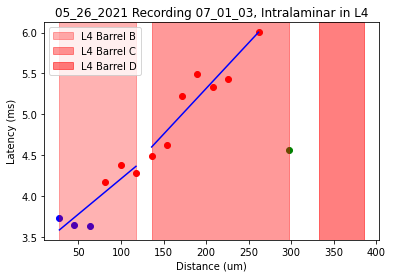

#  05_31_2021 05_01_04 Inter 5
2 Velocity: 228.36 um / ms
	P-value: 0.19175221021196842
2 Velocity: 413.64 um / ms
	P-value: 0.12408999628980297
Num points: 28


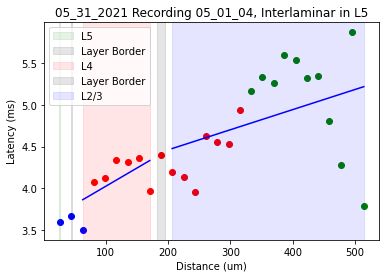

#  05_31_2021 06_01_05 Inter 2_3
2 Velocity: -49.36 um / ms
	P-value: 0.18942512902166667
2 Velocity: 690.32 um / ms
	P-value: 0.6853779714653121
2 Velocity: -103.68 um / ms
	P-value: 0.45111619313912843
Num points: 19


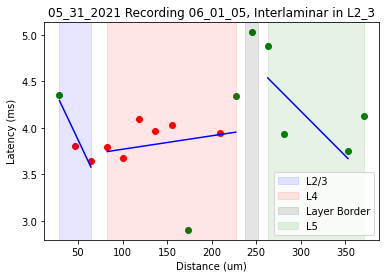

#  05_31_2021 06_01_05 Intra 2_3
2 Velocity: 188.45 um / ms
	P-value: 0.0011867188163734404
2 Velocity: -274.22 um / ms
	P-value: 0.6692579767962379
Num points: 16


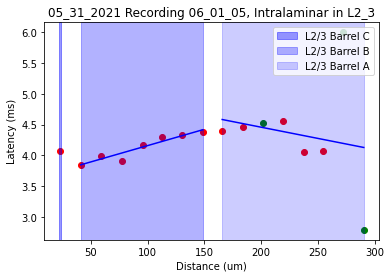

#  05_31_2021 07_01_05 Inter 2_3
2 Velocity: 113.75 um / ms
	P-value: 0.00014664349737122365
2 Velocity: -31.32 um / ms
	P-value: 0.09703499455138646
Num points: 18


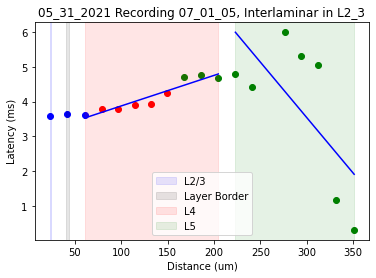

#  05_31_2021 07_01_05 Intra 2_3
2 Velocity: -230.77 um / ms
	P-value: nan
2 Velocity: 124.33 um / ms
	P-value: 0.003316881183425811
2 Velocity: -27.61 um / ms
	P-value: 0.0316202204122931
Num points: 17


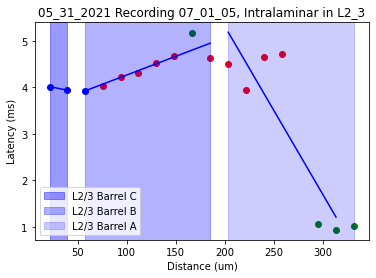

#  05_31_2021 09_01_05 Inter 2_3
2 Velocity: -172.92 um / ms
	P-value: nan
2 Velocity: 556.21 um / ms
	P-value: 0.0063453760892149035
Num points: 16


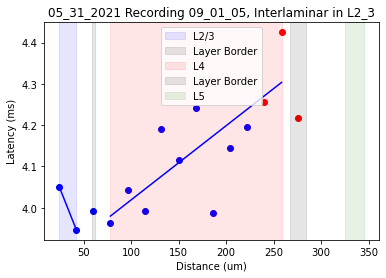

#  05_31_2021 10_01_05 Inter 2_3
2 Velocity: 159.99 um / ms
	P-value: 0.0011938432470936936
2 Velocity: -199.15 um / ms
	P-value: 0.20039727289331466
2 Velocity: 91.35 um / ms
	P-value: 0.4652517849490156
Num points: 21


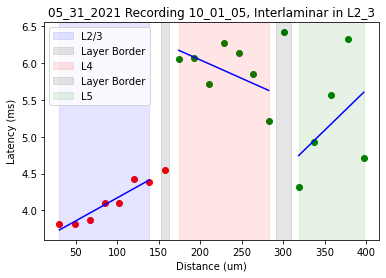

#  06_28_2021 03_01_02 Inter 5
2 Velocity: 143.87 um / ms
	P-value: nan
2 Velocity: 174.96 um / ms
	P-value: 0.0007995791713820293
2 Velocity: 311.96 um / ms
	P-value: 0.0004744129036394024
Num points: 27


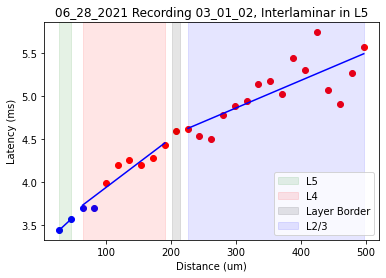

#  06_28_2021 04_01_02 Inter 5
2 Velocity: 236.23 um / ms
	P-value: 0.4953652289484126
2 Velocity: 229.67 um / ms
	P-value: 0.00030101975151870043
2 Velocity: 230.23 um / ms
	P-value: 2.319533989616622e-06
Num points: 27


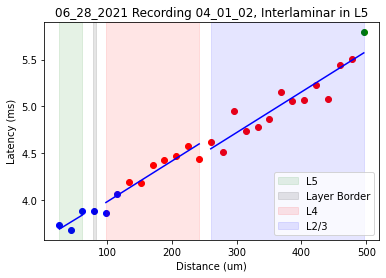

#  06_28_2021 05_01_02 Inter 5
2 Velocity: 307.17 um / ms
	P-value: nan
2 Velocity: 231.31 um / ms
	P-value: 0.0032081420434492383
2 Velocity: 265.07 um / ms
	P-value: 8.921180172799355e-05
Num points: 24


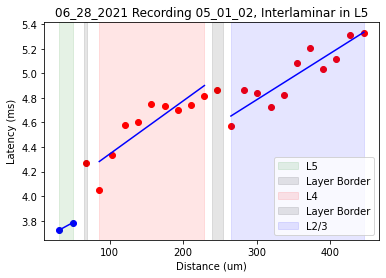

#  06_28_2021 06_01_01 Inter 5
2 Velocity: 286.18 um / ms
	P-value: 0.058575982930825866
2 Velocity: 231.18 um / ms
	P-value: 0.001399683252317352
2 Velocity: 178.48 um / ms
	P-value: 1.3560360853594354e-06
Num points: 27


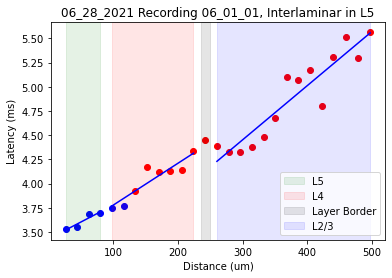

#  06_29_2021 02_01_02 Inter 5
2 Velocity: 134.0 um / ms
	P-value: 0.01755999937177568
2 Velocity: 264.17 um / ms
	P-value: 0.009159945168462434
Num points: 24


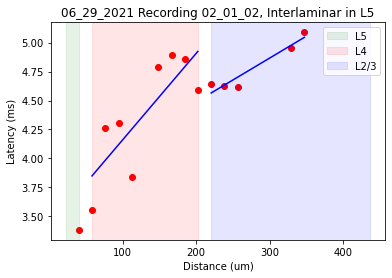

#  06_29_2021 02_01_02 Intra 5
2 Velocity: 141.17 um / ms
	P-value: 0.04037826712861383
Num points: 15


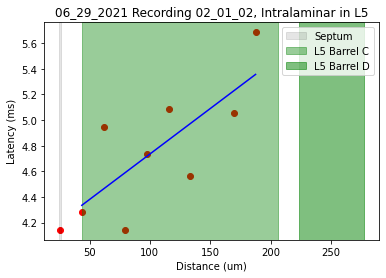

#  06_29_2021 04_01_02 Inter 5
2 Velocity: 120.83 um / ms
	P-value: 0.06665256806125351
2 Velocity: -292.08 um / ms
	P-value: 0.7977354326387492
Num points: 20


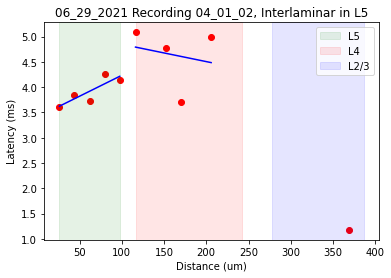

#  06_29_2021 04_01_02 Intra 5
2 Velocity: 118.58 um / ms
	P-value: 0.14069270735888711
Num points: 17


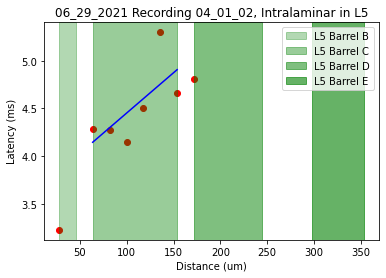

#  06_29_2021 05_01_01 Inter 5
2 Velocity: 138.35 um / ms
	P-value: 0.05982936550353496
2 Velocity: 237.47 um / ms
	P-value: 0.0004108440011917553
2 Velocity: 234.88 um / ms
	P-value: 0.026263733694269008
Num points: 21


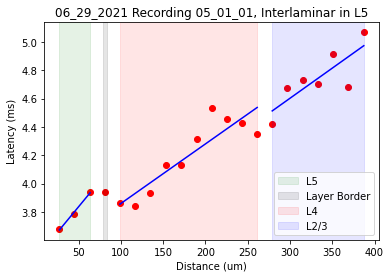

#  06_29_2021 05_01_01 Intra 5
2 Velocity: 76.22 um / ms
	P-value: 0.0006989514597339288
2 Velocity: 116.66 um / ms
	P-value: 0.12451764465650648
2 Velocity: -114.69 um / ms
	P-value: 0.43053194416895113
Num points: 15


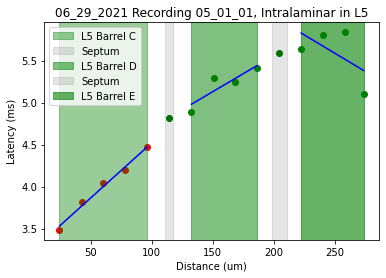

#  06_29_2021 07_01_02 Inter 5
2 Velocity: 92.56 um / ms
	P-value: 0.011461774094886128
2 Velocity: 346.83 um / ms
	P-value: 0.13975187150906204
2 Velocity: 250.88 um / ms
	P-value: 0.0016535533833064347
Num points: 23


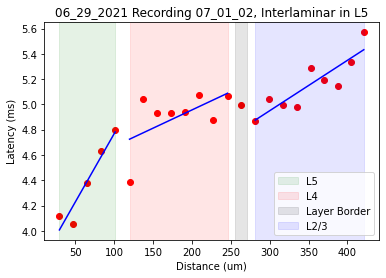

#  08_06_2021 02_01_02 Inter_L5 4
2 Velocity: 1623.44 um / ms
	P-value: 0.9780554444211265
2 Velocity: -140.2 um / ms
	P-value: 0.1486880109236277
Num points: 24


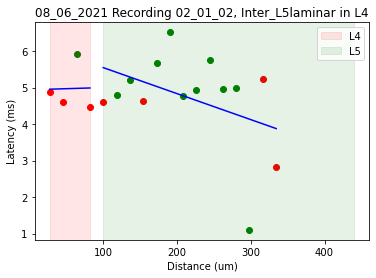

#  08_06_2021 02_01_02 Intra 4
2 Velocity: -118.96 um / ms
	P-value: 0.5248191968239198
2 Velocity: 160.62 um / ms
	P-value: 0.1257001734233749
Num points: 11


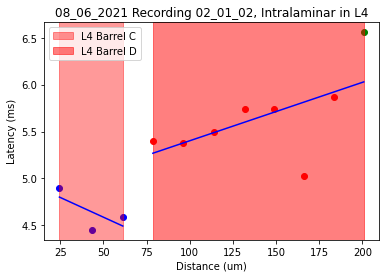

#  08_06_2021 04_01_01 Inter 2_3
2 Velocity: 203.74 um / ms
	P-value: 0.08336325593505967
2 Velocity: -1578.53 um / ms
	P-value: 0.7032745111975263
2 Velocity: 437.91 um / ms
	P-value: 0.8058843973914436
Num points: 18


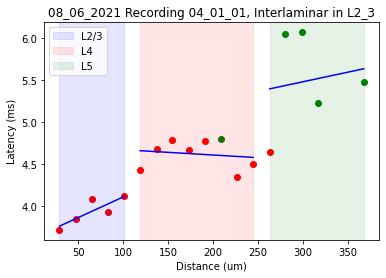

#  08_06_2021 04_01_01 Intra 2_3
2 Velocity: 730.31 um / ms
	P-value: 0.7801413906768244
2 Velocity: 15.92 um / ms
	P-value: 0.3704973393002793
Num points: 16


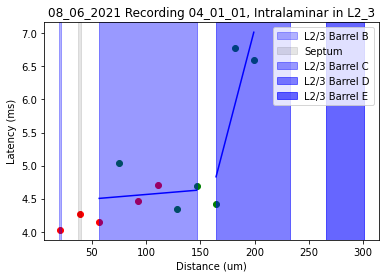

#  08_06_2021 05_01_03 Inter 2_3
2 Velocity: 85.73 um / ms
	P-value: 0.0019944280858696945
2 Velocity: 479.52 um / ms
	P-value: 0.666347044123765
2 Velocity: 27.35 um / ms
	P-value: 0.6107523071237864
Num points: 18


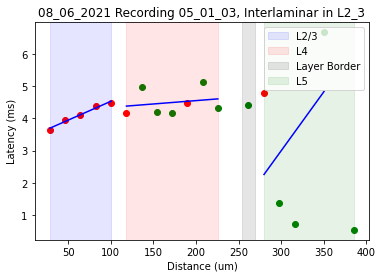

#  08_06_2021 05_01_03 Intra 2_3
2 Velocity: 258.24 um / ms
	P-value: nan
2 Velocity: 111.31 um / ms
	P-value: 0.005092527454900725
2 Velocity: 34.73 um / ms
	P-value: 0.7458198876518498
Num points: 17


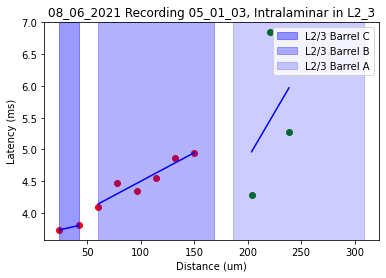

#  08_06_2021 07_01_03 Inter_L5 4
2 Velocity: 237.28 um / ms
	P-value: 0.15033512850277814
2 Velocity: -484.87 um / ms
	P-value: 0.6875886971789024
Num points: 22


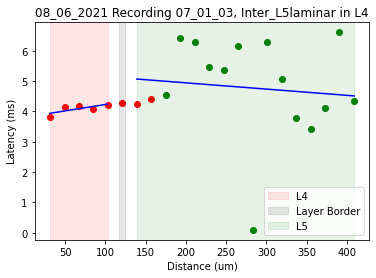

#  08_06_2021 07_01_03 Intra 4
2 Velocity: 107.37 um / ms
	P-value: 0.00016680633521417668
2 Velocity: 25.47 um / ms
	P-value: 0.31342854213894145
Num points: 13


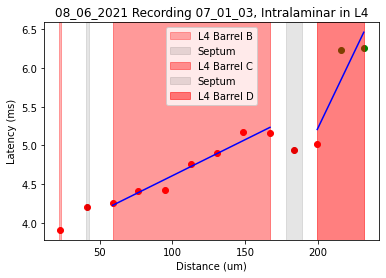

#  08_06_2021 08_01_03 Intra 2_3
2 Velocity: 88.28 um / ms
	P-value: 0.026242486743589585
2 Velocity: 176.54 um / ms
	P-value: 0.10078149187095287
2 Velocity: -468.44 um / ms
	P-value: 0.19632507571780272
Num points: 18


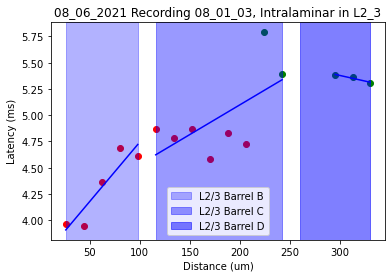

#  08_06_2021 08_01_03 Inter 2_3
2 Velocity: 117.31 um / ms
	P-value: 0.047796466719275676
2 Velocity: 243.8 um / ms
	P-value: 0.020797859337501095
2 Velocity: -51.37 um / ms
	P-value: 0.37291246191040334
Num points: 19


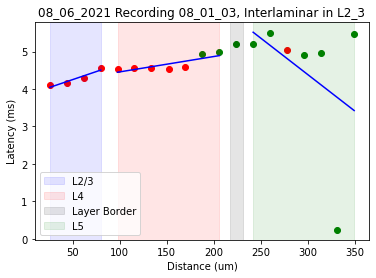

#  08_09_2021 05_01_06 Inter_L5 4
2 Velocity: 853.85 um / ms
	P-value: nan
2 Velocity: -124.84 um / ms
	P-value: 0.10384603198369903
Num points: 21


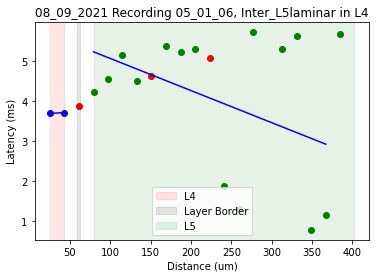

#  08_09_2021 06_01_04 Inter 2_3
2 Velocity: -80.91 um / ms
	P-value: 0.4059059373285496
2 Velocity: -137.6 um / ms
	P-value: 0.2771079020201024
2 Velocity: -3114.56 um / ms
	P-value: 0.9052555596394523
Num points: 19


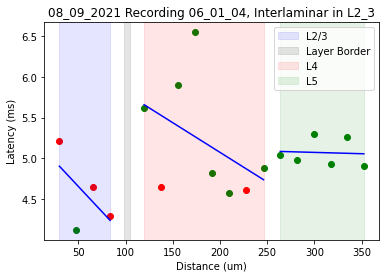

#  08_31_2021 03_01_02 Inter 2_3
2 Velocity: 187.05 um / ms
	P-value: 0.04612898343515714
2 Velocity: 148.82 um / ms
	P-value: 0.008378166981603135
2 Velocity: -34.16 um / ms
	P-value: 0.18458368017552337
Num points: 22


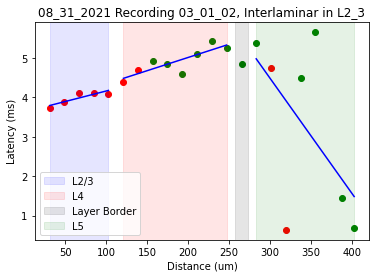

#  09_06_2021 02_01_06 Inter 2_3
2 Velocity: 118.17 um / ms
	P-value: 0.00031845088701261035
2 Velocity: 1724.59 um / ms
	P-value: 0.9659358468126058
2 Velocity: 44.46 um / ms
	P-value: 0.2884766414947017
Num points: 22


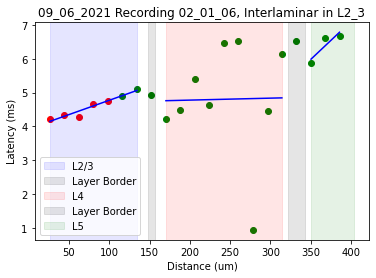

#  09_06_2021 03_01_04 Inter 2_3
2 Velocity: 1350.42 um / ms
	P-value: 0.8784521192214999
2 Velocity: -159.68 um / ms
	P-value: 0.595339881838095
2 Velocity: -4.94 um / ms
	P-value: nan
Num points: 15


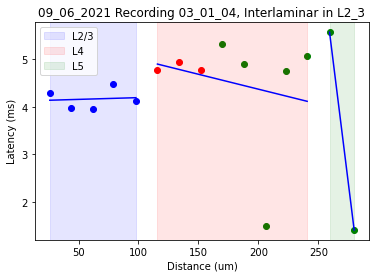

#  09_06_2021 04_01_04 Inter 2_3
2 Velocity: 147.67 um / ms
	P-value: 0.08274823286819881
2 Velocity: 32.28 um / ms
	P-value: 0.1266341691528786
2 Velocity: -83.83 um / ms
	P-value: 0.593965118658517
Num points: 18


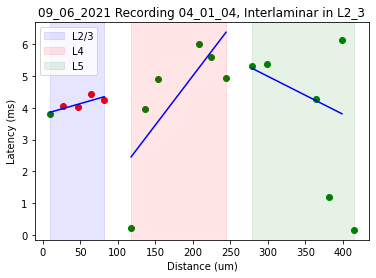

#  09_06_2021 04_01_04 Intra 2_3
2 Velocity: 145.19 um / ms
	P-value: 0.007930204331795681
2 Velocity: -89.11 um / ms
	P-value: 0.6563261854369824
Num points: 14


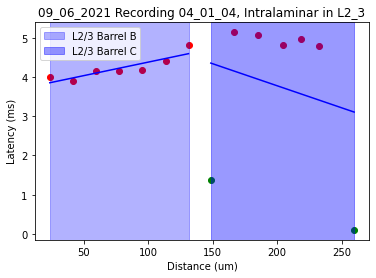

#  09_06_2021 07_01_04 Inter 2_3
2 Velocity: 133.33 um / ms
	P-value: 0.0022501027732596155
2 Velocity: 724.74 um / ms
	P-value: 0.01622575055346017
2 Velocity: -205.17 um / ms
	P-value: 0.7412884637761459
Num points: 25


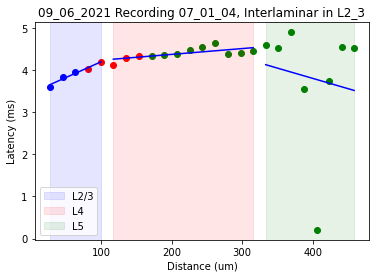

#  09_06_2021 07_01_04 Intra 2_3
2 Velocity: 151.52 um / ms
	P-value: 0.04630575683956984
2 Velocity: 320.31 um / ms
	P-value: 0.013082021637272628
Num points: 13


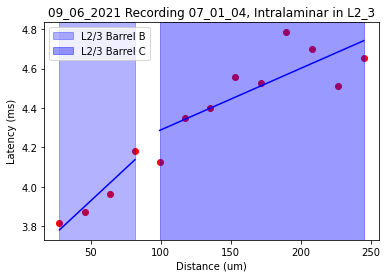

#  09_06_2021 08_01_04 Inter 2_3
2 Velocity: 110.24 um / ms
	P-value: 0.3266637251451943
2 Velocity: -68.2 um / ms
	P-value: 0.3001431547479832
Num points: 21


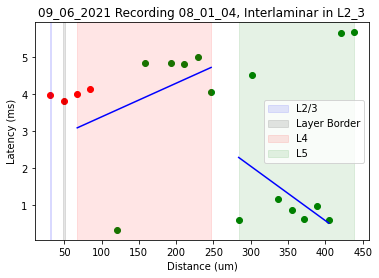

#  09_06_2021 08_01_04 Intra 2_3
2 Velocity: 172.95 um / ms
	P-value: 0.0055458175920777685
2 Velocity: -128.51 um / ms
	P-value: 0.644183880308896
Num points: 14


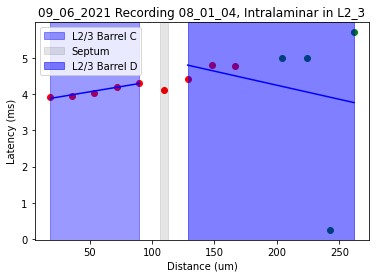

total_points: 1676
Unplotted plot keys: []


In [5]:
# load original CSV
        
#df = pd.read_csv(filename)
#df = pd.DataFrame(df, columns=['Date', 'Age_Days', 'Sex', 'Tx', 'Slice_Loc_Run',
#                              'Trial_x_Time', 'Stim_Intensity', 'Cx', 'n_Pulses',
#                              'Stim_Layer', 'Laminar', 'ROI_Id', 'SNR', 
#                               'Latency_Mono_Raw', 'Distance'])

df = df_combined
#perma_legend = image.imread('./images/figure_synapticity_legend.png')

df['Latency_Calc'] = df[latency_column] - 46.0  # 46 ms is stim time
df.drop(df[df['Latency_Calc'] <= 0].index, inplace=True)  # negative values are non-physical

# 6 um per pixel on new rig (see https://github.com/john-judge/TSM-to-ZDA/issues/12)
df['Distance'] *= 6.0

# targets to plot
laminar_val_target = "Inter"
layer_val_target = "5"
plot_all = True  # overrides above 2 lines
lin_regression_groups = ['synapticity', 'module'][1]
total_points = 0
min_roi_count = 7  # fewer than 7 ROIs excludes velocity measurement
unplotted_plot_keys = []

velocity_measurements = {}
colors = ['b', 'r', 'g']
# for each recording/laminar/direction measurement, plot latency vs distance
for date in df.Date.unique():
    cv_subset_date = df[(df['Date'] == date)]
    for rec_id in cv_subset_date.Slice_Loc_Run.unique():
        cv_subset_rec_id = cv_subset_date[(cv_subset_date['Slice_Loc_Run'] == rec_id)]
        for laminar_val in cv_subset_rec_id.Laminar.unique():
            cv_subset_lam = cv_subset_rec_id[(cv_subset_rec_id['Laminar'] == laminar_val)]
            for layer_val in cv_subset_lam.Stim_Layer.unique():
                plot_key = date + " " + rec_id + " " + laminar_val + " " + layer_val
                if plot_all or (laminar_val_target == laminar_val and layer_val_target == layer_val):
                    cv_subset = cv_subset_lam[(cv_subset_lam['Stim_Layer'] == layer_val)]
                    plt.clf()
                    #plt.scatter(cv_subset['Distance'], 
                    #            cv_subset['Latency_Calc'],
                    #            c='black')
                    print("# ", plot_key)
                    if plot_key in synapse_count_map:

                        # analyze and plot each synapse-count group separately
                        reg_lines = []
                        for i_synap in [0, 1, 2]:
                            ind_list = synapse_count_map[plot_key][i_synap]
                            for k in range(len(ind_list)-1, -1, -1):
                                if ind_list[k] > len(cv_subset['Distance'])-1:
                                    del ind_list[k]
                            try:
                                syn_cv_subset = cv_subset.iloc[ind_list]
                            except Exception as e:
                                print(ind_list, e)
                            dist = np.array(syn_cv_subset['Distance']).reshape(-1, 1)
                            latency = np.array(syn_cv_subset['Latency_Calc']).reshape(-1, 1)
                            plt.scatter(dist, latency, c=colors[i_synap])
                            
                            if dist.size > 1:
                                # linear regression for synapticity groups
                                if lin_regression_groups == 'synapticity':
                                    regr = linear_model.LinearRegression()
                                    regr.fit(dist, latency)
                                    params = np.append(regr.intercept_, regr.coef_)
                                    y_pred = regr.predict(dist)
                                    velocity = round(1 / regr.coef_[0][0], 5)

                                    # statistical significance analysis
                                    #define predictor and response variables
                                    y = syn_cv_subset['Latency_Calc']
                                    x = syn_cv_subset['Distance']

                                    #add constant to predictor variables
                                    x = sm.add_constant(x)

                                    #fit linear regression model
                                    model = sm.OLS(y, x).fit()

                                    pvalue = model.pvalues.loc['Distance']
                                    reg_lines.append([dist, y_pred, velocity, i_synap, pvalue])

                                    if velocity > 0 and dist.shape[0] > min_roi_count:
                                        vel_key = laminar_val + " " + layer_val
                                        if vel_key not in velocity_measurements:
                                            velocity_measurements[vel_key] = {}
                                        if i_synap not in velocity_measurements[vel_key]:
                                            velocity_measurements[vel_key][i_synap] = {"Velocity": [], "P-value": [], "Metadata": []}
                                        velocity_measurements[vel_key][i_synap]["Velocity"].append(velocity)
                                        velocity_measurements[vel_key][i_synap]["P-value"].append(pvalue)
                                        velocity_measurements[vel_key][i_synap]["Metadata"].append(date + " " + rec_id)

                        #plt.legend(["Other","Direct Stim", "Monosynaptic", "Disynaptic"])
                        # import permanent legend
                        # plt.imshow(perma_legend)
                        #imagebox = OffsetImage(perma_legend, zoom = 0.35)
                        #ab = AnnotationBbox(imagebox, xy=(0, 1), xycoords="axes fraction")
                        #plt.gca().add_artist(ab)
                            
                        # Find and draw layer/barrel boundaries on the plot
                        # find all the layer values in this subset, and find the min/max distances along trajectory
                        second_legend = []
                        for layer_barrel_loc in cv_subset.Layer.unique(): 
                            cv_subset_layer = cv_subset[(cv_subset['Layer'] == layer_barrel_loc)]
                            if "Edge" not in layer_barrel_loc:
                                disp_label = layer_barrel_loc.replace('2_3', 'L2/3')
                                disp_label = disp_label.replace('4', 'L4')
                                disp_label = disp_label.replace('5', 'L5')
                                disp_label = disp_label.replace('_', ' Barrel ')
                                second_legend.append(disp_label)
                            else:
                                if 'Inter' not in laminar_val:
                                    second_legend.append("Septum")
                                else:
                                    second_legend.append("Layer Border")
                            min_boundary = cv_subset_layer['Distance'].min()
                            max_boundary = cv_subset_layer['Distance'].max()
                            color = 'black'
                            if '2_3' in layer_barrel_loc:
                                color = 'blue'
                            elif '4' in layer_barrel_loc:
                                color = 'red'
                            elif '5' in layer_barrel_loc:
                                color = 'green'
                            alpha = 0.1
                            if 'A' in layer_barrel_loc:
                                alpha = 0.2
                            elif 'B' in layer_barrel_loc:
                                alpha = 0.3
                            elif 'C' in layer_barrel_loc:
                                alpha = 0.4
                            elif 'D' in layer_barrel_loc:
                                alpha = 0.5
                            elif 'E' in layer_barrel_loc:
                                alpha = 0.6
                            if 'Edge' in layer_barrel_loc:
                                color = 'black'
                                alpha = 0.1
                            if min_boundary == max_boundary:
                                min_boundary *= 0.97
                                max_boundary *= 1.03
                            
                            plt.axvspan(min_boundary, max_boundary, alpha=alpha, color=color)
                            
                                                            
                            # linear regression for module (layer/barrel)-based groups
                            if lin_regression_groups == 'module':
                                cv_subset_layer_filtered = cv_subset_layer[
                                    cv_subset_layer[synaptic_column].str.contains('Dir') |
                                    cv_subset_layer[synaptic_column].str.contains('Disyn') |
                                    cv_subset_layer[synaptic_column].str.contains('Mono')]
                                dist = np.array(cv_subset_layer_filtered['Distance']).reshape(-1, 1)
                                latency = np.array(cv_subset_layer_filtered['Latency_Calc']).reshape(-1, 1)
                                if dist.size > 1:
                                    regr = linear_model.LinearRegression()

                                    regr.fit(dist, latency)
                                    params = np.append(regr.intercept_, regr.coef_)
                                    y_pred = regr.predict(dist)
                                    velocity = round(1 / regr.coef_[0][0], 5)

                                    # statistical significance analysis
                                    #define predictor and response variables
                                    y = cv_subset_layer_filtered['Latency_Calc']
                                    x = cv_subset_layer_filtered['Distance']

                                    #add constant to predictor variables
                                    x = sm.add_constant(x)

                                    #fit linear regression model
                                    model = sm.OLS(y, x).fit()

                                    pvalue = model.pvalues.loc['Distance']
                                    reg_lines.append([dist, y_pred, velocity, i_synap, pvalue])

                                    if velocity > 0 and dist.shape[0] > min_roi_count:
                                        vel_key = laminar_val + " " + layer_val
                                        if vel_key not in velocity_measurements:
                                            velocity_measurements[vel_key] = {}
                                        if layer_barrel_loc not in velocity_measurements[vel_key]:
                                            velocity_measurements[vel_key][layer_barrel_loc] = {"Velocity": [], "P-value": [], "Metadata": []}
                                        velocity_measurements[vel_key][layer_barrel_loc]["Velocity"].append(velocity)
                                        velocity_measurements[vel_key][layer_barrel_loc]["P-value"].append(pvalue)
                                        velocity_measurements[vel_key][layer_barrel_loc]["Metadata"].append(date + " " + rec_id)

                        
                        # legend only for module shading
                        plt.legend(second_legend)
                        
                        for rl in reg_lines:
                            dist, y_pred, velocity, labeler, pvalue = rl
                            plt.plot(dist, y_pred, c='b')
                            if lin_regression_groups == 'synapticity':
                                print(str(labeler) + "-synapse Velocity:", round(velocity, 2), "um / ms")
                            elif lin_regression_groups == 'module':
                                print(str(labeler) + " Velocity:", round(velocity, 2), "um / ms")
                            print("\tP-value:", pvalue)

                    else:
                        unplotted_plot_keys.append(plot_key)

                    plt.title(date + " Recording " + rec_id + ", " + laminar_val + "laminar in L" + layer_val)
                    plt.xlabel('Distance (um)')
                    plt.ylabel('Latency (ms)')
                    total_points += len(cv_subset['Distance'])
                    print("Num points:", len(cv_subset['Distance']))
                    plt.show()
                    
print("total_points:", total_points)
print("Unplotted plot keys:", unplotted_plot_keys)

In [9]:
velocity_measurements

{'Inter 2_3': {'4': {'Velocity': [191.97128,
    398.10538,
    112.29168,
    60.4326,
    96.82927,
    199.15879,
    363.19697,
    160.90992,
    5.32543,
    690.31596,
    113.75404,
    556.21035,
    148.81629,
    1724.58705,
    724.74407,
    110.23981],
   'P-value': [0.0026962885031612312,
    0.283771547506159,
    0.02105224477003173,
    0.0001422421113415737,
    0.001514032438889688,
    0.0001345658344395269,
    0.035366593679226205,
    0.0010315848031326395,
    0.12168221598749542,
    0.6853779714653121,
    0.00014664349737122365,
    0.0063453760892149035,
    0.008378166981603135,
    0.9659358468126058,
    0.01622575055346017,
    0.3266637251451943],
   'Metadata': ['10_02_2020 02_01_05',
    '01_18_2021 07_01_02',
    '04_13_2021 05_01_01',
    '04_13_2021 08_01_01',
    '05_25_2021 02_01_03',
    '05_25_2021 04_01_03',
    '05_25_2021 05_01_04',
    '05_25_2021 09_01_04',
    '05_26_2021 05_01_03',
    '05_31_2021 06_01_05',
    '05_31_2021 07_01_05',
 

In [7]:
# Make box and whisker plots comparing velocities by interlaminar, intralaminar, and stimulation site 

# vel_key is laminar direction[dir*] + stim layer
#    * 2/3 or 5 direction if inter from 4
if lin_regression_groups == 'synapticity':
    # Plot 1: 5 bars
    plot_1_data = {}
    for vel_key in velocity_measurements:
        if 1 not in velocity_measurements[vel_key]:
            continue
        vel_data = velocity_measurements[vel_key][1]["Velocity"]  # monosyn only
        laminar, layer = vel_key.split(" ")
        laminar = laminar[:5]
        new_key = laminar + "_" + layer
        if new_key not in plot_1_data:
            plot_1_data[new_key] = []
        plot_1_data[new_key] += vel_data
    plt.bar([i for i in range(len(plot_1_data.keys()))], 
            [np.mean(plot_1_data[k]) for k in plot_1_data],
            tick_label=[k for k in plot_1_data],
            yerr=[np.std(plot_1_data[k])/np.sqrt(len(plot_1_data[k])) for k in plot_1_data],
            error_kw={"capsize": 5.0})
    plt.ylabel("Velocity (um/msec)")
    plt.title("Velocity Comparisons")
    plt.show()

    # group data for more specific comparisons
    plot_2_data = {}
    plot_3_data = {}
    for vel_key in velocity_measurements:
        if 1 not in velocity_measurements[vel_key]:
            continue
        vel_data = velocity_measurements[vel_key][1]["Velocity"]  # monosyn only
        laminar, layer = vel_key.split(" ")

        if laminar not in plot_2_data:
            plot_2_data[laminar] = []
        plot_2_data[laminar] += vel_data

        if "Inter" in laminar:
            if layer in ["2_3", "5"]:
                layer = "L2/3, L5"
            elif layer == "4":
                layer = "L4"
            if layer not in plot_3_data:
                plot_3_data[layer] = []
            plot_3_data[layer] += vel_data

    # Plot 2: box and whiskers comparing inter vs intra
    P.figure()
    labels = ['Interlaminar', 'Intralaminar']
    bp = P.boxplot([plot_2_data[lbl[:5]] for lbl in labels],
                   labels=labels,
                   sym="")  # hides fliers
    for i in range(len(labels)):
        lbl = labels[i]
        y = plot_2_data[lbl[:5]]
        x = np.random.normal(1+i, 0.04, size=len(y))
        P.plot(x, y, 'r.', alpha=0.2)
    plt.ylabel("Velocity (um/msec)")
    plt.title("Velocity Comparison: Laminar Directions")
    P.show()

    # Plot 3: box and whisker trajectories only inter, comparing L4 vs L2/3, L5
    P.figure()
    labels = ["L2/3, L5", 'L4']
    bp = P.boxplot([plot_3_data[lbl] for lbl in labels],
                   labels=labels,
                   sym="")  # hides fliers
    for i in range(len(labels)):
        lbl = labels[i]
        y = plot_3_data[lbl]
        x = np.random.normal(1+i, 0.04, size=len(y))
        P.plot(x, y, 'r.', alpha=0.2)
    plt.ylabel("Velocity (um/msec)")
    plt.ylabel("Stimulation Layer")
    plt.title("Velocity Comparison: Stimulation Layer")
    P.show()



 Module 4

 Module 2_3


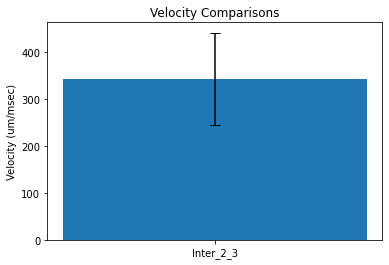


 Module 2_3_C

 Module 2_3_B


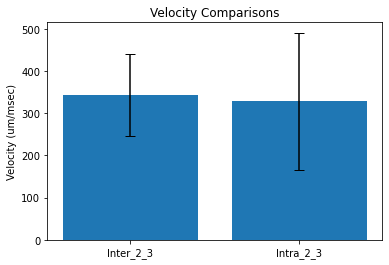


 Module 2_3


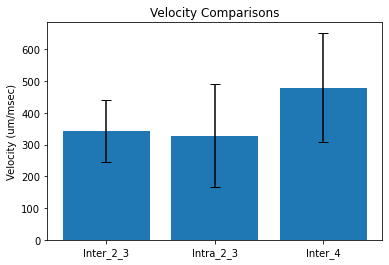


 Module 4_C

 Module 4_D


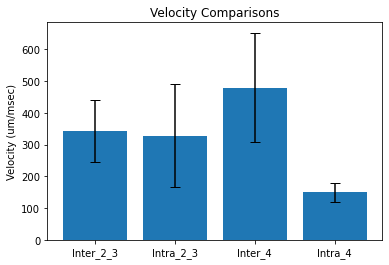


 Module 2_3

 Module 4


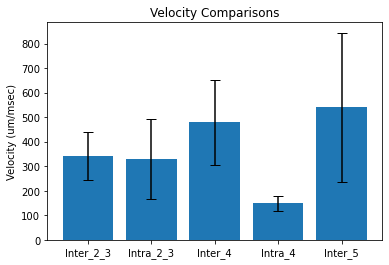


 Module 5


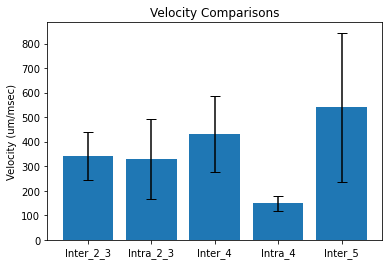


 Module 5_C


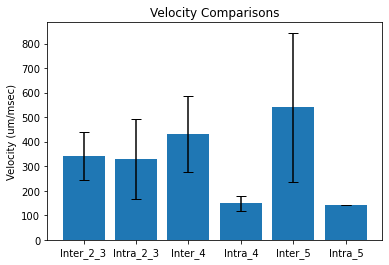


 Module 4

 Module 2_3


KeyError: 'Intra'

<Figure size 432x288 with 0 Axes>

In [11]:
# Make box and whisker plots comparing velocities by interlaminar, intralaminar, and stimulation site 

# vel_key is laminar direction[dir*] + stim layer
#    * 2/3 or 5 direction if inter from 4
if lin_regression_groups == 'module':
    # Plot 1: 5 bars
    plot_1_data = {}
    for vel_key in velocity_measurements:
        for layer_key in velocity_measurements[vel_key]:
            print("\n Module", layer_key)
            vel_data = velocity_measurements[vel_key][layer_key]["Velocity"]  # monosyn only
            laminar, layer = vel_key.split(" ")
            laminar = laminar[:5]
            new_key = laminar + "_" + layer
            if new_key not in plot_1_data:
                plot_1_data[new_key] = []
            plot_1_data[new_key] += vel_data
        plt.bar([i for i in range(len(plot_1_data.keys()))], 
                [np.mean(plot_1_data[k]) for k in plot_1_data],
                tick_label=[k for k in plot_1_data],
                yerr=[np.std(plot_1_data[k])/np.sqrt(len(plot_1_data[k])) for k in plot_1_data],
                error_kw={"capsize": 5.0})
        plt.ylabel("Velocity (um/msec)")
        plt.title("Velocity Comparisons")
        plt.show()

    # group data for more specific comparisons
    plot_2_data = {}
    plot_3_data = {}
    for vel_key in velocity_measurements:
        for layer_key in velocity_measurements[vel_key]:
            print("\n Module", layer_key)
            vel_data = velocity_measurements[vel_key][layer_key]["Velocity"]  # monosyn only
            laminar, layer = vel_key.split(" ")

            if laminar not in plot_2_data:
                plot_2_data[laminar] = []
            plot_2_data[laminar] += vel_data

            if "Inter" in laminar:
                if layer in ["2_3", "5"]:
                    layer = "L2/3, L5"
                elif layer == "4":
                    layer = "L4"
                if layer not in plot_3_data:
                    plot_3_data[layer] = []
                plot_3_data[layer] += vel_data

        # Plot 2: box and whiskers comparing inter vs intra
        P.figure()
        labels = ['Interlaminar', 'Intralaminar']
        bp = P.boxplot([plot_2_data[lbl[:5]] for lbl in labels],
                       labels=labels,
                       sym="")  # hides fliers
        for i in range(len(labels)):
            lbl = labels[i]
            y = plot_2_data[lbl[:5]]
            x = np.random.normal(1+i, 0.04, size=len(y))
            P.plot(x, y, 'r.', alpha=0.2)
        plt.ylabel("Velocity (um/msec)")
        plt.title("Velocity Comparison: Laminar Directions")
        P.show()

        # Plot 3: box and whisker trajectories only inter, comparing L4 vs L2/3, L5
        P.figure()
        labels = ["L2/3, L5", 'L4']
        bp = P.boxplot([plot_3_data[lbl] for lbl in labels],
                       labels=labels,
                       sym="")  # hides fliers
        for i in range(len(labels)):
            lbl = labels[i]
            y = plot_3_data[lbl]
            x = np.random.normal(1+i, 0.04, size=len(y))
            P.plot(x, y, 'r.', alpha=0.2)
        plt.ylabel("Velocity (um/msec)")
        plt.ylabel("Stimulation Layer")
        plt.title("Velocity Comparison: Stimulation Layer")
        P.show()
